# AutoML for Images - Mask Object Detection - AzureML sdkV2

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
# Import required libraries
import sys
import platform
import psutil

from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.automl import SearchSpace, ObjectDetectionPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

In [249]:
sys.version

'3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]'

In [250]:
print('Uname:', platform.uname())
print('Machine :', platform.machine())
print('Node :', platform.node())
print('Processor :', platform.processor())
print('Release :', platform.release())
print()
print('System :', platform.system())
print('Version :', platform.version())
print('Platform :', platform.platform())
print("Python version: ", sys.version)
print("Python version info: ", sys.version_info)
psutil.virtual_memory()
print()
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")
print(f"Current CPU frequency: {psutil.cpu_freq().current}")
print(f"Min CPU frequency: {psutil.cpu_freq().min}")
print(f"Max CPU frequency: {psutil.cpu_freq().max}")

Uname: uname_result(system='Linux', node='standardds11cpu', release='5.15.0-1022-azure', version='#27~20.04.1-Ubuntu SMP Mon Oct 17 02:03:50 UTC 2022', machine='x86_64')
Machine : x86_64
Node : standardds11cpu
Processor : x86_64
Release : 5.15.0-1022-azure

System : Linux
Version : #27~20.04.1-Ubuntu SMP Mon Oct 17 02:03:50 UTC 2022
Platform : Linux-5.15.0-1022-azure-x86_64-with-glibc2.31
Python version:  3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
Python version info:  sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)

Number of physical cores: 2
Number of logical cores: 2
Current CPU frequency: 2593.904
Min CPU frequency: 0.0
Max CPU frequency: 0.0


## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [4]:
sid = "xxxxxxx"  # Azuresubscription
rg = "xxxxxxx"  # Azure ML workspace resource group
ws = "xxxxxxx"  # Azure ML workspace

In [5]:
credential = DefaultAzureCredential()
ml_client = None

try:
    ml_client = MLClient.from_config(credential)

except Exception as ex:
    print(ex)
    subscription_id = sid
    resource_group = rg
    workspace = ws
    ml_client = MLClient(credential,
                         subscription_id,
                         resource_group,
                         workspace)

Found the config file in: /config.json


# 2. MLTable with input Training Data

In order to generate models for computer vision tasks with automated machine learning, you need to bring labeled image data as input for model training in the form of an MLTable. You can create an MLTable from labeled training data in JSONL format. If your labeled training data is in a different format (like, pascal VOC or COCO), you can use a conversion script to first convert it to JSONL, and then create an MLTable. Alternatively, you can use Azure Machine Learning's [data labeling tool](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects) to manually label images, and export the labeled data to use for training your AutoML model.

## 2.1. Images

In [6]:
dataset_dir = 'train'

In [7]:
training_images_list = os.listdir(dataset_dir)

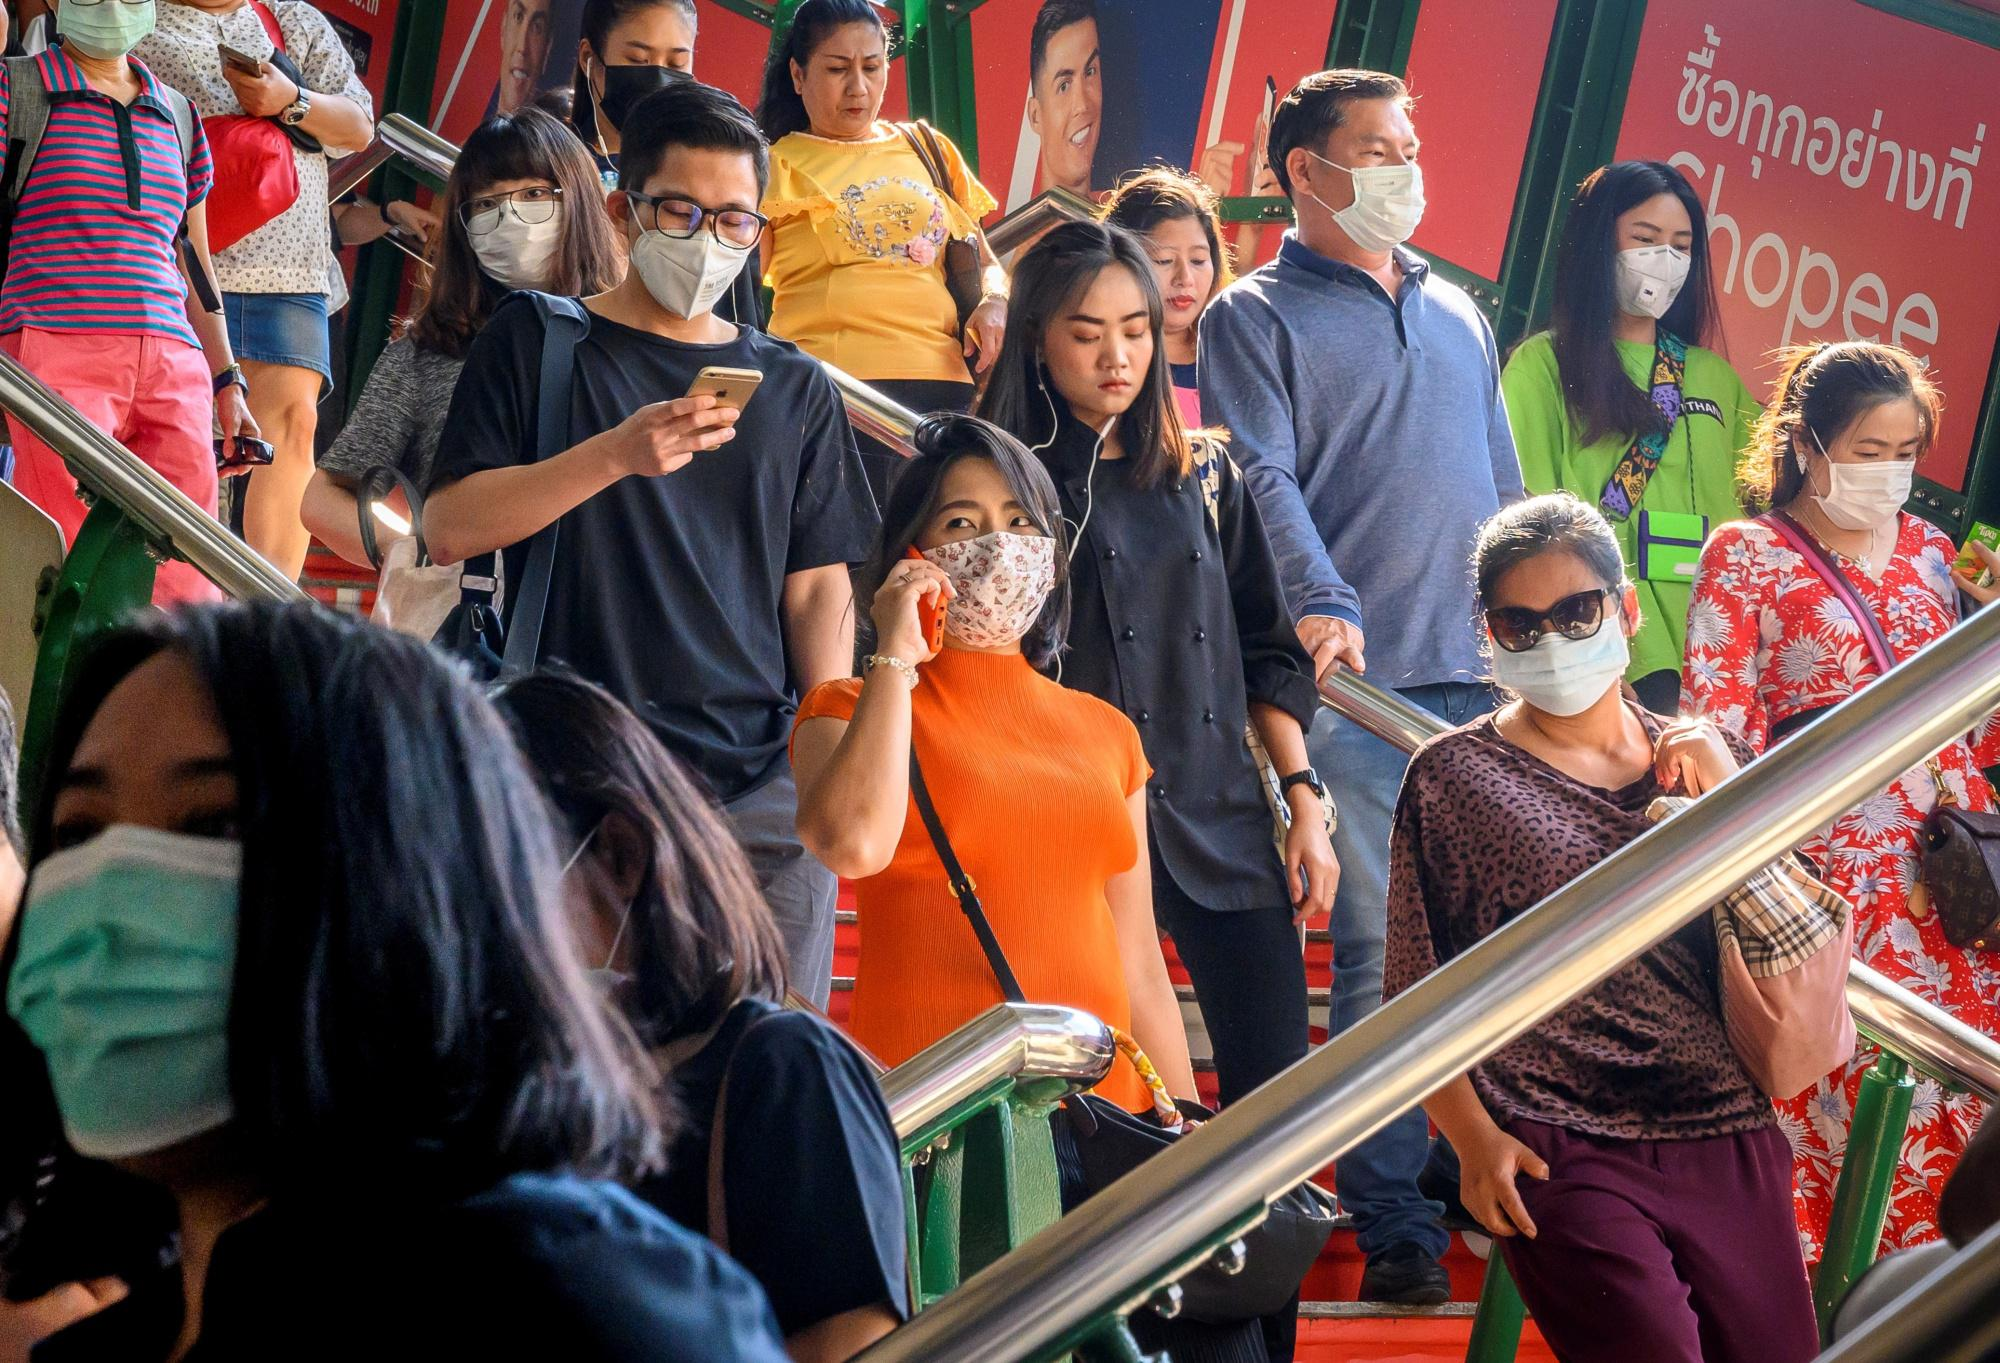

In [251]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, training_images_list[0])
Image(filename=sample_image, width=640, height=480)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

[Check this notebook for AML data asset example](../../../assets/data/data.ipynb)

In [9]:
training_images_list = os.listdir("train")
valid_images_list = os.listdir("valid")

len(training_images_list), len(valid_images_list)

(108, 32)

In [10]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="mask-items images Object detection",
    name="mask-items-images-object-detection",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'mask-items-images-object-detection', 'description': 'mask-items images Object detection', 'tags': {}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/data/mask-items-images-object-detection/versions/3', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/object_detection', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fa42c59c760>, 'serialize': <msrest.serialization.Serializer object at 0x7fa42c59c640>, 'version': '3', 'latest_version': None, 'path': 'azureml://subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml/datastores/wor

## 2.3. Using the JSONL labels files

In [11]:
import json
import os
import xml.etree.ElementTree as ET

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join('train')
validation_mltable_path = os.path.join('valid')

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

#train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = "train/covidmask_train.jsonl"
validation_annotations_file = "valid/covidmask_valid.jsonl"

## 2.4. Create MLTable data input
Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [12]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [13]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

To create data input from TabularDataset created using V1 sdk, specify the `type` as `AssetTypes.MLTABLE`, `mode` as `InputOutputModes.DIRECT` and `path` in the following format `azureml:<tabulardataset_name>:<version>`.

In [14]:
"""
# Training MLTable with v1 TabularDataset
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsTrainingDataset:1",
    mode=InputOutputModes.DIRECT
)

# Validation MLTable with v1 TabularDataset
my_validation_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsValidationDataset:1",
    mode=InputOutputModes.DIRECT
)
"""

'\n# Training MLTable with v1 TabularDataset\nmy_training_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsTrainingDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n\n# Validation MLTable with v1 TabularDataset\nmy_validation_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsValidationDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n'

# 3. Compute target setup

We will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [15]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")

except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


# 4. Configure and run the AutoML for Images Object Detection training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm and hyperparameters to be used, perform a sweep over a manually specified hyperparameter space, or the system can automatically perform a hyperparameter sweep for you.


## 4.1. Automatic hyperparameter sweeping for your models (AutoMode)

When using AutoML for Images, we can perform an automatic hyperparameter sweep to find the optimal model (we call this functionality AutoMode). The system will choose a model architecture and values for the learning_rate, number_of_epochs, training_batch_size, etc. based on the number of runs. There is no need to specify the hyperparameter search space, sampling method or early termination policy. A number of runs between 10 and 20 will likely work well on many datasets.

AutoMode is triggered by setting `max_trials` to a value greater than 1 in limits and by omitting the hyperparameter space, sampling method and termination policy.

The following functions configure AutoML image jobs for automatic sweeps:
### image_object_detection() function parameters:
The `image_object_detection()` factory function allows user to configure the training job.

- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-cluster' present in the workspace. You can replace it any other compute in the workspace.
- `experiment_name` - The name of the experiment. An experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data' and 'validation_data'.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter `training_data` must always be provided.

### set_limits() function parameters:
This is an optional configuration method to configure limits parameters such as timeouts.

- `timeout_minutes` - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. If not specified, the default job's total timeout is 6 days (8,640 minutes).
- `max_trials` - Parameter for maximum number of configurations to sweep. Must be an integer between 1 and 1000. When exploring just the default hyperparameters for a given model algorithm, set this parameter to 1. Default value is 1.
- `max_concurrent_trials` - Maximum number of runs that can run concurrently. If not specified, all runs launch in parallel. If specified, must be an integer between 1 and 100. Default value is 1.
    NOTE: The number of concurrent runs is gated on the resources available in the specified compute target. Ensure that the compute target has the available resources for the desired concurrency.



In [16]:
# general job parameters
exp_name = "covid19mask-image-objectdetection"

In [17]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="mean_average_precision",
    tags={"my_custom_tag": "My custom value"},
)

image_object_detection_job.set_limits(
    max_trials=5,
    max_concurrent_trials=2,
)

### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [18]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ImageObjectDetectionJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_OBJECT_DETECTION: 'ImageObjectDetection'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/ad6e886e779783962fa137033ad750c2/train'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/3f496589e2ec416b22968b65828e583f/valid'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'eager_hominy_5sl47ks8xm', 'description': None, 'tags': {'my_custom_tag': 'My custom value'}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/eager_hominy_5sl47ks8xm', 'Resource__source_path': None, 'base_pat

In [19]:
ml_client.jobs.stream(returned_job.name)

RunId: eager_hominy_5sl47ks8xm
Web View: https://ml.azure.com/runs/eager_hominy_5sl47ks8xm?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: eager_hominy_5sl47ks8xm
Web View: https://ml.azure.com/runs/eager_hominy_5sl47ks8xm?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



## 4.2. Individual runs

If AutoMode does not meet your needs, you can launch individual runs to explore model algorithms; we provide sensible default hyperparameters for each algorithm. You can also launch individual runs for the same model algorithm and different hyperparameter combinations. The model algorithm is specified using the model_name parameter. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

The following function can be used to configure AutoML jobs for individual runs:
### set_training_parameters() function parameters:
This is an optional configuration method to configure fixed settings or parameters that don't change during the parameter space sweep. Some of the key parameters of this function are:

- `model_name` - The name of the ML algorithm that we want to use in training job. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms) for supported model algorithm.
- `number_of_epochs` - The number of training epochs. It must be positive integer (default value is 15).
- `layers_to_freeze` - The number of layers to freeze in model for transfer learning. It must be a positive integer (default value is 0).
- `early_stopping` - It enable early stopping logic during training, It must be boolean value (default is True).   
- `optimizer` - Type of optimizer to use in training. It must be either sgd, adam, adamw (default is sgd).
- `distributed` - It enable distributed training if compute target contain multiple GPUs. It must be boolean value (default is True).

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the job for your AutoML Image runs as follows:

In [20]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

# Set limits
image_object_detection_job.set_limits(timeout_minutes=60)

# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(model_name="yolov5")

In [21]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

Created job: ImageObjectDetectionJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_OBJECT_DETECTION: 'ImageObjectDetection'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/ad6e886e779783962fa137033ad750c2/train'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/3f496589e2ec416b22968b65828e583f/valid'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'tough_car_0g5mvwl6l0', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/tough_car_0g5mvwl6l0', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mou

In [22]:
ml_client.jobs.stream(returned_job.name)

RunId: tough_car_0g5mvwl6l0
Web View: https://ml.azure.com/runs/tough_car_0g5mvwl6l0?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: tough_car_0g5mvwl6l0
Web View: https://ml.azure.com/runs/tough_car_0g5mvwl6l0?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



## 4.3. Manual hyperparameter sweeping for your model

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `yolov5` and `fasterrcnn_resnet50_fpn` models, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories, choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc., to generate a model with the optimal 'mean_average_precision'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [24]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ObjectDetectionPrimaryMetrics.MEAN_AVERAGE_PRECISION,
    tags={"task": "Object Detection"},
)

In [25]:
# Set limits
image_object_detection_job.set_limits(
    timeout_minutes=60,
    max_trials=10,
    max_concurrent_trials=2,
)

In [26]:
# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(
    early_stopping=True, evaluation_frequency=1
)

In [27]:
# Configure sweep settings
image_object_detection_job.set_sweep(
    sampling_algorithm="random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [28]:
# Define search space
image_object_detection_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["yolov5"]),
            learning_rate=Uniform(0.0001, 0.01),
            model_size=Choice(["medium", "large"]),  # model-specific
            # image_size=Choice(640, 704, 768),  # model-specific; might need GPU with large memory
        ),
        SearchSpace(
            model_name=Choice(["fasterrcnn_resnet50_fpn"]),
            learning_rate=Uniform(0.0001, 0.001),
            optimizer=Choice(["sgd", "adam", "adamw"]),
            min_size=Choice([600, 800]),  # model-specific
            # warmup_cosine_lr_warmup_epochs=Choice([0, 3]),
        ),
    ]
)

In [29]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ImageObjectDetectionJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_OBJECT_DETECTION: 'ImageObjectDetection'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/ad6e886e779783962fa137033ad750c2/train'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/3f496589e2ec416b22968b65828e583f/valid'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'coral_feast_pc34zycsmq', 'description': None, 'tags': {'task': 'Object Detection'}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/coral_feast_pc34zycsmq', 'Resource__source_path': None, 'base_path': '/mnt/

In [30]:
ml_client.jobs.stream(returned_job.name)

RunId: coral_feast_pc34zycsmq
Web View: https://ml.azure.com/runs/coral_feast_pc34zycsmq?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: coral_feast_pc34zycsmq
Web View: https://ml.azure.com/runs/coral_feast_pc34zycsmq?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child jobs' tab in the UI of the main automl image job from above, which is the HyperDrive parent run. Then you can go into the 'Trials' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Trials' tab:

In [38]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

SweepJob({'type': 'sweep', 'status': 'Completed', 'log_files': None, 'name': 'coral_feast_pc34zycsmq_HD', 'description': None, 'tags': {'_aml_system_azureml.automlComponent': 'AutoML', '_aml_system_max_concurrent_jobs': '2', 'max_concurrent_jobs': '2', '_aml_system_max_total_jobs': '10', 'max_total_jobs': '10', '_aml_system_max_duration_minutes': '60', 'max_duration_minutes': '60', '_aml_system_policy_config': '{"name":"Bandit","properties":{"evaluation_interval":2,"delay_evaluation":6,"slack_factor":0.2}}', 'policy_config': '{"name":"Bandit","properties":{"evaluation_interval":2,"delay_evaluation":6,"slack_factor":0.2}}', '_aml_system_generator_config': '{"name":"RANDOM","parameter_space":{"model":["choice",[[{"model_size":["choice",[["medium","large"]]],"learning_rate":["uniform",[0.0001,0.01]],"model_name":["choice",[["yolov5"]]]},{"min_size":["choice",[[600,800]]],"learning_rate":["uniform",[0.0001,0.001]],"model_name":["choice",[["fasterrcnn_resnet50_fpn"]]],"optimizer":["choice",[["sgd","adam","adamw"]]]}]]]},"properties":null}', 'generator_config': '{"name":"RANDOM","parameter_space":{"model":["choice",[[{"model_size":["choice",[["medium","large"]]],"learning_rate":["uniform",[0.0001,0.01]],"model_name":["choice",[["yolov5"]]]},{"min_size":["choice",[[600,800]]],"learning_rate":["uniform",[0.0001,0.001]],"model_name":["choice",[["fasterrcnn_resnet50_fpn"]]],"optimizer":["choice",[["sgd","adam","adamw"]]]}]]]},"properties":null}', '_aml_system_primary_metric_config': '{"name":"mean_average_precision","goal":"maximize"}', 'primary_metric_config': '{"name":"mean_average_precision","goal":"maximize"}', '_aml_system_platform_config': '{"ServiceAddress": "https://westeurope.api.azureml.ms", "SubscriptionId": "b8acd8e6-3841-4717-8469-82e36dad9ae5", "ResourceGroupName": "azureml-rg", "WorkspaceName": "azureml", "ExperimentName": "covid19mask-image-objectdetection", "Definition": {"Configuration": null, "Attribution": null, "TelemetryValues": {"amlClientRequestId": "", "amlClientSessionId": "", "subscriptionId": "b8acd8e6-3841-4717-8469-82e36dad9ae5", "maxConcurrentRuns": 2, "maxTotalRuns": 10, "tenantId": "", "maxDurationMinutes": 60, "samplingMethod": "RANDOM", "computeTarget": "ComputeTarget"}, "Overrides": {"Script": "hd_object_detection_dnn_driver.py", "UseAbsolutePath": false, "Arguments": ["--data-folder", "$AZUREML_DATAREFERENCE_default", "--labels-file-root", "$AZUREML_DATAREFERENCE_labels_file_root"], "SourceDirectoryDataStore": null, "Framework": 0, "Target": "gpu-cluster", "DataReferences": {}, "Data": {}, "OutputData": {}, "Datacaches": [], "JobName": null, "MaxRunDurationSeconds": null, "NodeCount": 1, "InstanceTypes": [], "Priority": null, "CredentialPassthrough": false, "Identity": null, "Environment": {"Name": "AzureML-AutoML-DNN-Vision-GPU", "Version": "107", "AssetId": "azureml://registries/azureml/environments/AzureML-AutoML-DNN-Vision-GPU/versions/107", "AutoRebuild": true, "Python": {"InterpreterPath": "python", "UserManagedDependencies": false, "CondaDependencies": {"channels": ["conda-forge", "cerebis"], "dependencies": ["python=3.7", "pip=21.3.1", "numpy~=1.21.6", "libffi=3.3", "pycocotools=2.0.2", "shap=0.39.0", "recordclass=0.14.3", "llvmlite=0.36.0", {"pip": ["azureml-core==1.48.0", "azureml-mlflow==1.48.0", "azureml-dataset-runtime==1.48.0", "azureml-telemetry==1.48.0", "azureml-responsibleai==1.48.0", "azureml-automl-core==1.48.0", "azureml-automl-runtime==1.48.0.post1", "azureml-train-automl-client==1.48.0", "azureml-defaults==1.48.0", "azureml-interpret==1.48.0", "azureml-train-automl-runtime==1.48.0.post1", "azureml-automl-dnn-vision==1.48.0", "azureml-dataprep>=2.24.4"]}], "name": "azureml_54a17edef71b712e10caf62b536f0b3b"}, "BaseCondaEnvironment": null}, "EnvironmentVariables": {}, "Docker": {"BaseImage": "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.1-cudnn8-ubuntu20.04:20230103.v1", "Platform": {"Os": "Linux", "Architecture": "amd64"}, "BaseDockerfile": null, "BaseImageRegistry": null, "Enab

# 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

### Obtain the tracking URI for MLFlow

In [31]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml


In [32]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml


In [33]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [34]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'log_loss_train': 0.20944082815022697,
 'mean_average_precision': 0.88328,
 'precision': 0.67089,
 'recall': 0.91831}, params={}, tags={'_azureml.ComputeTargetType': 'STANDARD_NC6',
 'automl_best_child_run_id': 'coral_feast_pc34zycsmq_HD_3',
 'fit_time': '<NaN>;',
 'iteration': '<0>;',
 'mlflow.rootRunId': 'coral_feast_pc34zycsmq',
 'mlflow.runName': 'coral_feast_pc34zycsmq',
 'mlflow.user': 'Serge Retkowsky',
 'model_explain_run': 'best_run',
 'pipeline_id_000': 'UnkownPipelineId',
 'predicted_cost': '<0>;',
 'run_algorithm': '<>;',
 'run_preprocessor': '<>;',
 'score': '<0.91063>;',
 'task': 'Object Detection',
 'training_percent': '<0>;'}>, info=<RunInfo: artifact_uri='azureml://experiments/covid19mask-image-objectdetection/runs/coral_feast_pc34zycsmq/artifacts', end_time=1675266188643, experiment_id='4d2e8909-1e10-484d-a8f7-b59b4564633d', lifecycle_stage='active', run_id='coral_feast_pc34zycsmq', run_name='coral_feast_pc34zycsmq', run_uuid

In [35]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'task': 'Object Detection', 'model_explain_run': 'best_run', '_azureml.ComputeTargetType': 'STANDARD_NC6', 'pipeline_id_000': 'UnkownPipelineId', 'score': '<0.91063>;', 'predicted_cost': '<0>;', 'fit_time': '<NaN>;', 'training_percent': '<0>;', 'iteration': '<0>;', 'run_preprocessor': '<>;', 'run_algorithm': '<>;', 'automl_best_child_run_id': 'coral_feast_pc34zycsmq_HD_3', 'mlflow.rootRunId': 'coral_feast_pc34zycsmq', 'mlflow.runName': 'coral_feast_pc34zycsmq', 'mlflow.user': 'Serge Retkowsky'}


### Get the AutoML best child run

In [36]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id: coral_feast_pc34zycsmq_HD_3
Best child run: 
<Run: data=<RunData: metrics={'log_loss_train': 0.20944082815022697,
 'mean_average_precision': 0.88328,
 'precision': 0.67089,
 'recall': 0.91831}, params={}, tags={'hyperparameters': '{"model": {"learning_rate": 0.0002044373199955205, '
                    '"min_size": 600, "model_name": "fasterrcnn_resnet50_fpn", '
                    '"optimizer": "adam"}}',
 'mlflow.parentRunId': 'coral_feast_pc34zycsmq_HD',
 'mlflow.rootRunId': 'coral_feast_pc34zycsmq',
 'mlflow.runName': 'magenta_parang_zhcc0znd',
 'mlflow.source.name': 'hd_object_detection_dnn_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Serge Retkowsky'}>, info=<RunInfo: artifact_uri='azureml://experiments/covid19mask-image-objectdetection/runs/coral_feast_pc34zycsmq_HD_3/artifacts', end_time=1675264338620, experiment_id='4d2e8909-1e10-484d-a8f7-b59b4564633d', lifecycle_stage='active', run_id='coral_feast_pc34zycsmq_HD_3', run_name='magenta_par

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [37]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

0
log_loss_train          0.209441
precision               0.670890
recall                  0.918310
mean_average_precision  0.883280

## Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [39]:
# Create local folder
local_dir = "./artifact_downloads"

if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [40]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/object_detection/artifact_downloads/outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'generated_code', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


In [43]:
!ls $local_dir/* -lh

total 472M
-rwxrwxrwx 1 root root  657 Feb  1 15:44 conda_env_v_1_0_0.yml
drwxrwxrwx 2 root root    0 Feb  1 15:44 generated_code
drwxrwxrwx 2 root root    0 Feb  1 15:44 mlflow-model
-rwxrwxrwx 1 root root 472M Feb  1 15:44 model.pt
-rwxrwxrwx 1 root root   27 Feb  1 15:44 run_id.txt
-rwxrwxrwx 1 root root 2.2K Feb  1 15:44 scoring_file_v_1_0_0.py


In [44]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "train_artifacts", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/object_detection/artifact_downloads/train_artifacts
Artifacts: ['labels.json', 'model.onnx', 'model.pt', 'per_label_metrics.json', 'score_script.py', 'train_df.csv', 'val_df.csv']


In [45]:
!ls $local_dir/* -lh

./artifact_downloads/outputs:
total 472M
-rwxrwxrwx 1 root root  657 Feb  1 15:44 conda_env_v_1_0_0.yml
drwxrwxrwx 2 root root    0 Feb  1 15:44 generated_code
drwxrwxrwx 2 root root    0 Feb  1 15:44 mlflow-model
-rwxrwxrwx 1 root root 472M Feb  1 15:44 model.pt
-rwxrwxrwx 1 root root   27 Feb  1 15:44 run_id.txt
-rwxrwxrwx 1 root root 2.2K Feb  1 15:44 scoring_file_v_1_0_0.py

./artifact_downloads/train_artifacts:
total 630M
-rwxrwxrwx 1 root root   29 Feb  1 15:45 labels.json
-rwxrwxrwx 1 root root 158M Feb  1 15:45 model.onnx
-rwxrwxrwx 1 root root 472M Feb  1 15:45 model.pt
-rwxrwxrwx 1 root root  983 Feb  1 15:45 per_label_metrics.json
-rwxrwxrwx 1 root root 4.9K Feb  1 15:45 score_script.py
-rwxrwxrwx 1 root root 123K Feb  1 15:45 train_df.csv
-rwxrwxrwx 1 root root  30K Feb  1 15:45 val_df.csv


In [46]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

# 6. Register best model and deploy

## 6.1 Create managed online endpoint

In [47]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [50]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime
import time

online_endpoint_name = "covid19mask-od-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Covid19 mask detection model",
    auth_mode="key",
    tags={"task": "object detection"},
)

print(online_endpoint_name)

covid19mask-od-02011551735267


In [51]:
start = time.time()

ml_client.begin_create_or_update(endpoint).result()

print(f"Processing time: {((time.time() - start) / 60):.2f} minutes")

Processing time: 3.12 minutes


## 6.2 Register best model and deploy

### Register model

In [52]:
model_name = "covid19-masks-mlflow-model"

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="Covid-19 mask object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path=mlflow_model_dir,
#     name=model_name,
#     description="my sample object detection model",
#     type=AssetTypes.MLFLOW_MODEL,
# )

registered_model = ml_client.models.create_or_update(model)

In [53]:
registered_model.id

'/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/models/covid19-masks-mlflow-model/versions/1'

### Deploy

In [54]:
deployment = ManagedOnlineDeployment(
    name="covid19-mask-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS3_V2",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [55]:
start = time.time()

ml_client.online_deployments.begin_create_or_update(deployment).result()

print()
print(f"Processing time: {((time.time() - start) / 60):.2f} minutes")

Check: endpoint covid19mask-od-02011551735267 exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Processing time: 41.64 minutes


In [56]:
start = time.time()

endpoint.traffic = {"covid19-mask-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

print(f"Processing time: {(time.time() - start):.0f} seconds")

Processing time: 34 seconds


### Get endpoint details

In [57]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

print(endpoint.traffic)
print(endpoint.scoring_uri)

{'covid19-mask-mlflow-deploy': 100}
https://covid19mask-od-02011551735267.westeurope.inference.ml.azure.com/score


### Test the deployment

In [58]:
test_dir = 'test_images'

home_dir = os.getcwd()
os.makedirs(test_dir, exist_ok=True)
os.chdir(test_dir)

!wget https://www.dropbox.com/s/jqiemc0wwc7a3t6/test_mask.zip
!unzip test_mask.zip
os.remove("test_mask.zip")

os.chdir(home_dir)

--2023-02-01 16:37:03--  https://www.dropbox.com/s/jqiemc0wwc7a3t6/test_mask.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/jqiemc0wwc7a3t6/test_mask.zip [following]
--2023-02-01 16:37:04--  https://www.dropbox.com/s/raw/jqiemc0wwc7a3t6/test_mask.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ab6c53c16b9fda5309cd8d8a1.dl.dropboxusercontent.com/cd/0/inline/B1obTqnsdwncq9P5XPYhn48GAqtNsqj0rI6ED8qgO03DCDvoOIDdi-2W7oH2qTCBkALZeehqRfWvZquaG_p-wugDocmLgM4BlmmYheMEDA9cV9alI-uj8kw4RzC514AC5OnoPyXA5wQRBVlSzw4Ch1DVaD0KX4elfehwV-SSMIIuxw/file# [following]
--2023-02-01 16:37:05--  https://uc6ab6c53c16b9fda5309cd8d8a1.dl.dropboxusercontent.com/cd/0/inline/B1obTqnsdwncq9P5XPYhn48GAqtNsqj0rI6ED8qgO03DCDvoOIDdi-2W7oH2qTCBkALZeehqRf

In [62]:
import glob

testing_images_list = [file for file in glob.glob(test_dir + '/*.*') 
                       if file.endswith(('jpeg', 'png', 'jpg', 'JPG', 'JPEG', 'PNG'))]
testing_images_list

['test_images/test_mask _1.jpg',
 'test_images/test_mask _2.jpg',
 'test_images/test_mask _3.jpg',
 'test_images/test_mask _4.jpg',
 'test_images/test_mask _5.jpg',
 'test_images/test_mask _6.jpg']

In [76]:
import base64
from pathlib import Path
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

from PIL import Image as PILImage

In [68]:
def read_image(image_path):
    """
    Read image
    """
    with open(image_path, "rb") as f:
        return f.read()

In [206]:
def get_predictions(sample_image):
    """
    Get predictions from the model
    """
    request_json = {
        "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
        }
    }

    request_file_name = "sample_request_data.json"

    with open(request_file_name, "w") as request_file:
        json.dump(request_json, request_file)

    resp = ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name=deployment.name,
        request_file=request_file_name,
    )

    detections = json.loads(resp)

    idx = 1
    nb_mask = 0
    nb_nomask = 0
    print("\033[1;31;34m")
    
    for detect in detections[0]["boxes"]:
        label = detect["label"]
        box = detect["box"]
        conf_score = detect["score"]
        print(str(f"{idx:02}"), label, "with score =", conf_score, "\nBox:", box, "\n")
        
        if label == 'mask':
            nb_mask += 1
        if label != 'mask':
            nb_nomask += 1
        
        idx += 1

    print("\033[1;31;32mNumber of mask =", nb_mask)
    print("\033[1;31;91mNumber of no-mask =", nb_nomask)
    
    return resp

In [226]:
def visualise_predictions(min_conf=0.8):
    """
    Visualize predicted labels and boxes on the image
    """
    %matplotlib inline

    img_np = mpimg.imread(sample_image)
    img = PILImage.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size
    nb_mask = 0
    nb_nomask = 0
    idx = 1
    
    print("\033[1;31;34m")

    fig, ax = plt.subplots(1, figsize=(12, 8))
    # Display the image
    ax.imshow(img_np)

    # draw box and label for each detection
    detections = json.loads(resp)
    for detect in detections[0]["boxes"]:
        label = detect["label"]
        box = detect["box"]
        conf_score = detect["score"]

        if conf_score > min_conf:
            ymin, xmin, ymax, xmax = (
                box["topY"],
                box["topX"],
                box["bottomY"],
                box["bottomX"],
            )
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)
            
            print(
                f"{idx:02}",
                f"{detect['label']}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
                f"{round(width, 3)}, {round(height, 3)}] with score = {round(conf_score, 3)}"
            )
            
            if label == "mask":
                nb_mask += 1
            if label != "mask":
                nb_nomask += 1
            
            color = "lime" if label == "mask" else "red"

            rect = patches.Rectangle(
                (topleft_x, topleft_y),
                width,
                height,
                linewidth=3,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            plt.text(topleft_x, topleft_y - 10, 
                     label + ' = ' + str(round(conf_score, 3)),
                     color=color, fontsize=12)
            idx += 1
        
    plt.savefig(os.path.splitext(sample_image)[0] + '_results' + os.path.splitext(sample_image)[1], dpi=300)
    
    print("\n\033[1;31;32mNumber of mask =", nb_mask)
    print("\033[1;31;91mNumber of no-mask =", nb_nomask)
        
    plt.show()

### Test 1

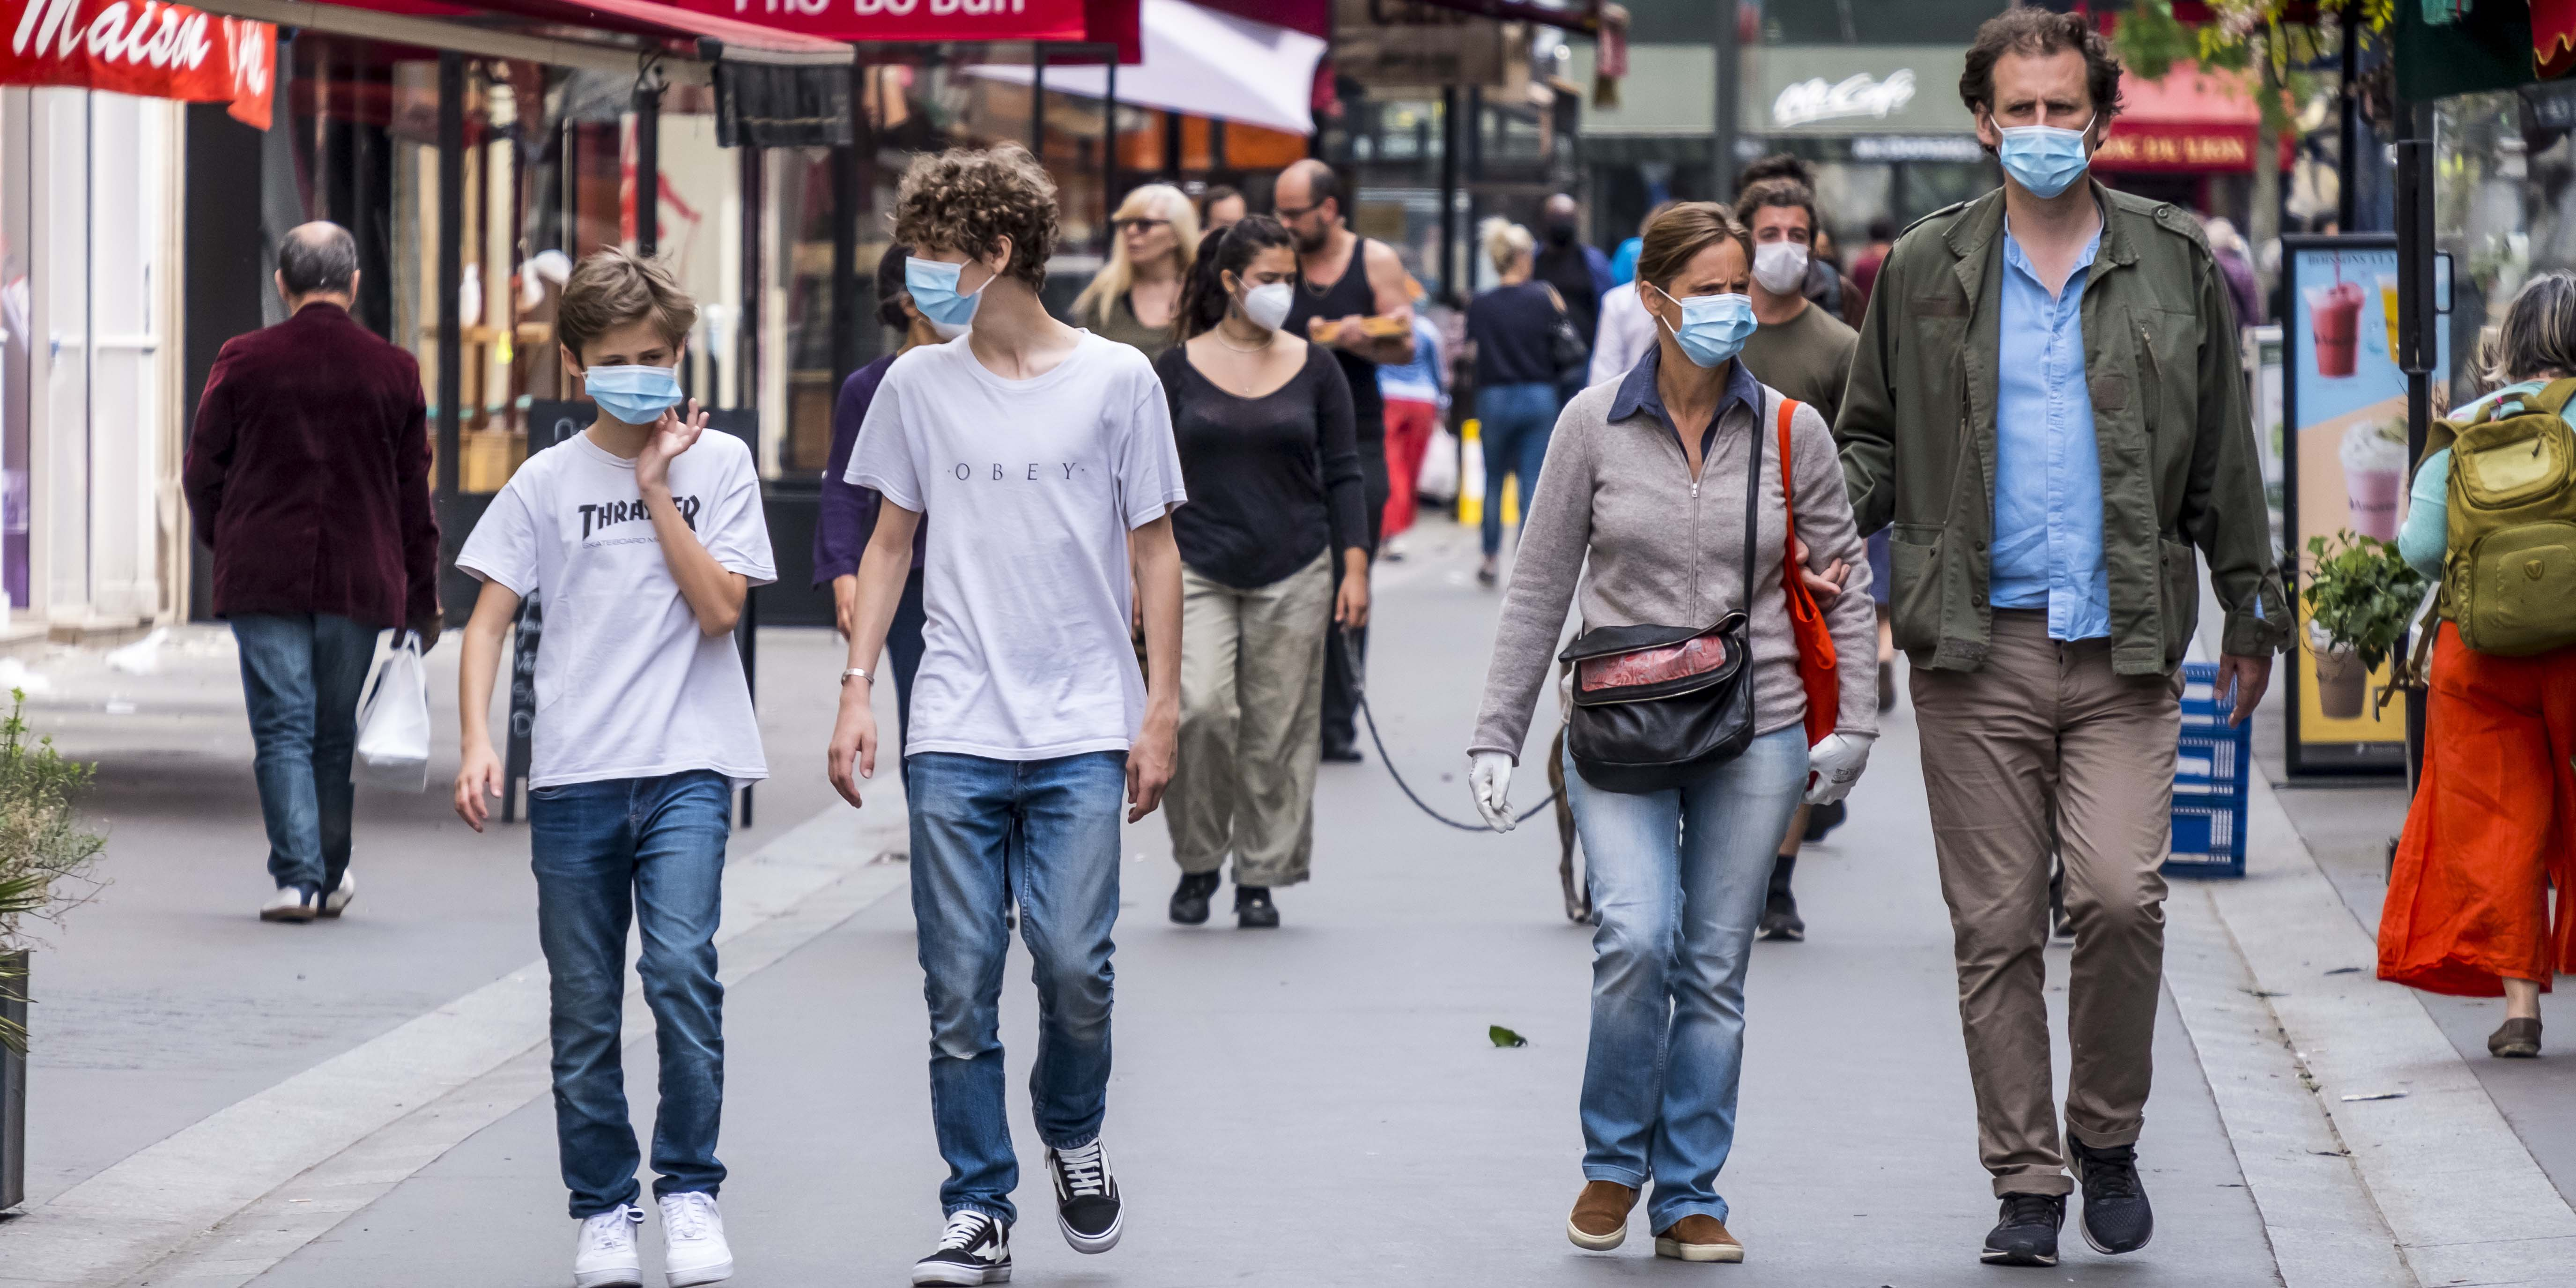

In [270]:
%matplotlib inline
from IPython.display import Image

sample_image = os.path.join(testing_images_list[0])
Image(filename=sample_image) 

In [271]:
resp = get_predictions(sample_image)


01 mask with score = 0.9932069182395935 
Box: {'topX': 0.6349110412597656, 'topY': 0.1468827184041341, 'bottomX': 0.6829209899902344, 'bottomY': 0.2889057922363281} 

02 mask with score = 0.9912431240081787 
Box: {'topX': 0.763073984781901, 'topY': 0.0016715113321940105, 'bottomX': 0.8229837544759114, 'bottomY': 0.15806776682535809} 

03 mask with score = 0.9868223667144775 
Box: {'topX': 0.21849276224772135, 'topY': 0.1885070546468099, 'bottomX': 0.2721319834391276, 'bottomY': 0.33921424865722655} 

04 mask with score = 0.9805895090103149 
Box: {'topX': 0.47351852416992185, 'topY': 0.16316136678059895, 'bottomX': 0.5082080586751302, 'bottomY': 0.2627600860595703} 

05 mask with score = 0.9768989682197571 
Box: {'topX': 0.34351799011230466, 'topY': 0.10691312154134115, 'bottomX': 0.4093433380126953, 'bottomY': 0.2629962666829427} 

06 mask with score = 0.951887309551239 
Box: {'topX': 0.6758002217610677, 'topY': 0.11860547383626302, 'bottomX': 0.7083973693847656, 'bottomY': 0.24056793


01 mask: [3492.011, 403.927, 264.055, 390.563] with score = 0.993
02 mask: [4196.907, 4.597, 329.504, 430.09] with score = 0.991
03 mask: [1201.71, 518.394, 295.016, 414.445] with score = 0.987
04 mask: [2604.352, 448.694, 190.792, 273.896] with score = 0.981
05 mask: [1889.349, 294.011, 362.039, 429.229] with score = 0.977
06 mask: [3716.901, 326.165, 179.284, 335.397] with score = 0.952
07 no-mask: [2732.284, 326.855, 150.814, 212.398] with score = 0.915
08 no-mask: [2371.138, 375.639, 186.889, 252.089] with score = 0.915

Number of mask = 6
Number of no-mask = 2


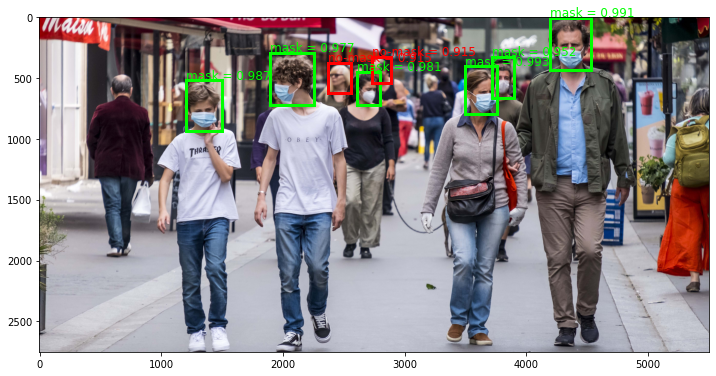

In [272]:
visualise_predictions(min_conf=0.8)

## Test 2

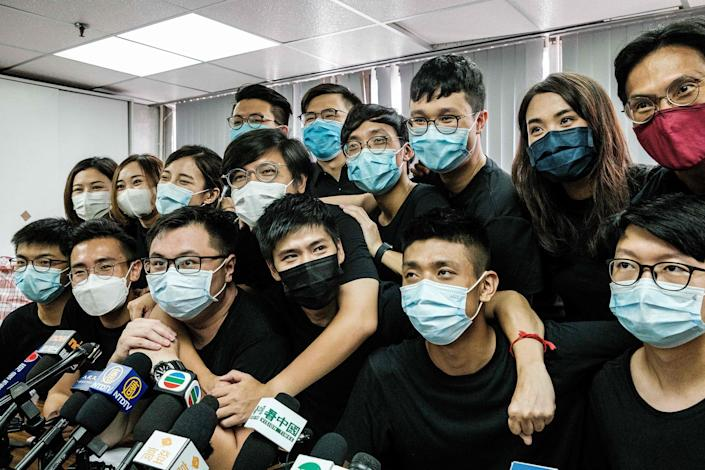

In [255]:
sample_image = os.path.join(testing_images_list[1])
Image(filename=sample_image) 

In [256]:
resp = get_predictions(sample_image)


01 mask with score = 0.9936680197715759 
Box: {'topX': 0.7346646284500139, 'topY': 0.1376379837774872, 'bottomX': 0.8695678032014739, 'bottomY': 0.39262652516564067} 

02 mask with score = 0.9932616353034973 
Box: {'topX': 0.5621588073662577, 'topY': 0.43303505924587854, 'bottomX': 0.7114903468046093, 'bottomY': 0.7358537014816361} 

03 mask with score = 0.9925202131271362 
Box: {'topX': 0.8611374155963223, 'topY': 0.40136621949668716, 'bottomX': 0.9997301282023429, 'bottomY': 0.7466301766779267} 

04 mask with score = 0.9906854033470154 
Box: {'topX': 0.20924287484140364, 'topY': 0.4365776966330603, 'bottomX': 0.34501422207400584, 'bottomY': 0.6793181812623904} 

05 mask with score = 0.989180862903595 
Box: {'topX': 0.5753884660256188, 'topY': 0.09470441305577655, 'bottomX': 0.6965336783709329, 'bottomY': 0.3715011774996087} 

06 mask with score = 0.9838232398033142 
Box: {'topX': 0.021080814824088398, 'topY': 0.4506580180835246, 'bottomX': 0.1114229705097678, 'bottomY': 0.6571931409


01 mask: [517.939, 64.69, 95.107, 119.845] with score = 0.994
02 mask: [396.322, 203.526, 105.279, 142.325] with score = 0.993
03 mask: [607.102, 188.642, 97.708, 162.274] with score = 0.993
04 mask: [147.516, 205.192, 95.719, 114.088] with score = 0.991
05 mask: [405.649, 44.511, 85.407, 130.094] with score = 0.989
06 mask: [14.862, 211.809, 63.691, 97.072] with score = 0.984
07 mask: [111.625, 146.545, 51.308, 73.918] with score = 0.983
08 mask: [262.592, 193.386, 91.891, 117.627] with score = 0.982
09 mask: [69.347, 217.271, 73.455, 100.199] with score = 0.981
10 mask: [340.955, 96.974, 71.397, 97.997] with score = 0.978
11 mask: [223.92, 124.936, 90.07, 101.093] with score = 0.962
12 mask: [158.405, 143.439, 65.615, 72.241] with score = 0.958
13 mask: [64.142, 151.447, 53.052, 72.465] with score = 0.958
14 mask: [297.369, 77.116, 61.421, 86.962] with score = 0.953
15 mask: [225.084, 77.747, 69.584, 65.8] with score = 0.946
16 mask: [607.775, 23.564, 97.225, 128.141] with score = 0

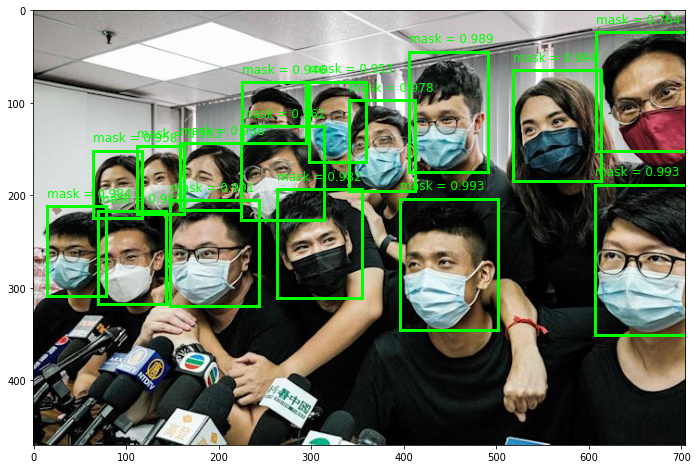

In [257]:
visualise_predictions(min_conf=0.5)

## Test 3

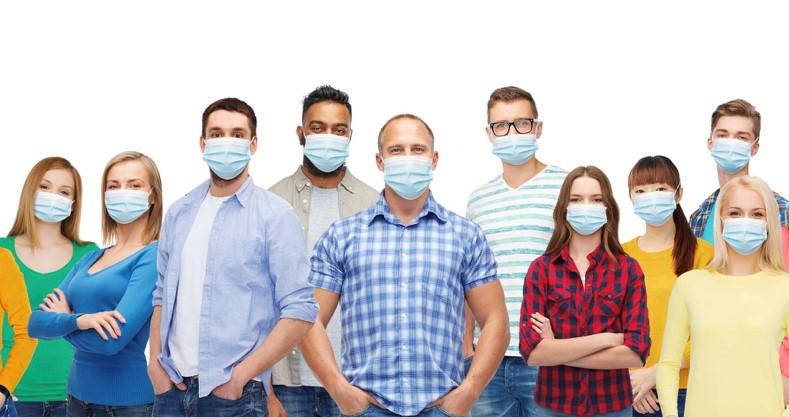

In [258]:
sample_image = os.path.join(testing_images_list[2])
Image(filename=sample_image) 

In [259]:
resp = get_predictions(sample_image)


01 mask with score = 0.9890945553779602 
Box: {'topX': 0.6109225504198789, 'topY': 0.18999605814615886, 'bottomX': 0.694129224600771, 'bottomY': 0.4002081044514974} 

02 mask with score = 0.9883893728256226 
Box: {'topX': 0.7071753144789372, 'topY': 0.3889318339029948, 'bottomX': 0.7795662363195209, 'bottomY': 0.5704417419433594} 

03 mask with score = 0.9868003129959106 
Box: {'topX': 0.12702510346400056, 'topY': 0.34584579467773435, 'bottomX': 0.20843960262080122, 'bottomY': 0.5442015075683594} 

04 mask with score = 0.986772358417511 
Box: {'topX': 0.37780635346400054, 'topY': 0.18701253255208333, 'bottomX': 0.4517452290404736, 'bottomY': 0.4216331481933594} 

05 mask with score = 0.9850400686264038 
Box: {'topX': 0.252142360872109, 'topY': 0.22192832946777344, 'bottomX': 0.33294322816285793, 'bottomY': 0.4340320841471354} 

06 mask with score = 0.9847686290740967 
Box: {'topX': 0.7953284713140143, 'topY': 0.3573851267496745, 'bottomX': 0.8652459367256332, 'bottomY': 0.551751302083


01 mask: [482.018, 79.228, 65.65, 87.658] with score = 0.989
02 mask: [557.961, 162.185, 57.116, 75.69] with score = 0.988
03 mask: [100.223, 144.218, 64.236, 82.714] with score = 0.987
04 mask: [298.089, 77.984, 58.338, 97.837] with score = 0.987
05 mask: [198.94, 92.544, 63.752, 88.447] with score = 0.985
06 mask: [627.514, 149.03, 55.165, 81.051] with score = 0.985
07 mask: [704.647, 92.12, 59.396, 83.572] with score = 0.984
08 mask: [379.76, 106.28, 62.174, 94.794] with score = 0.984
09 mask: [24.644, 150.622, 61.148, 77.238] with score = 0.982
10 mask: [715.151, 174.135, 60.413, 81.122] with score = 0.972

Number of mask = 10
Number of no-mask = 0


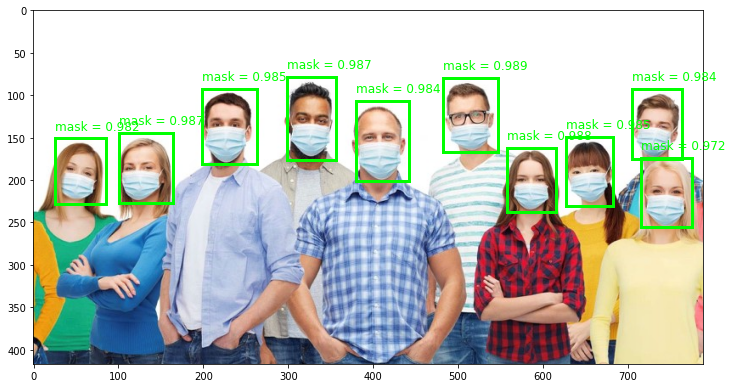

In [260]:
visualise_predictions()

## Test 4

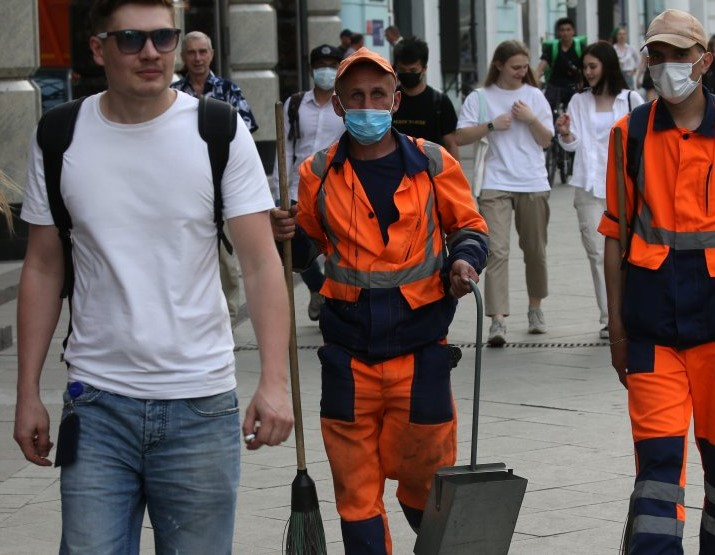

In [261]:
sample_image = os.path.join(testing_images_list[3])
Image(filename=sample_image)

In [262]:
resp = get_predictions(sample_image)


01 mask with score = 0.9901934266090393 
Box: {'topX': 0.4695285144865204, 'topY': 0.0846759287516276, 'bottomX': 0.5578775356470612, 'bottomY': 0.2622686513264974} 

02 mask with score = 0.9856298565864563 
Box: {'topX': 0.8989403284893135, 'topY': 0.008825289408365885, 'bottomX': 0.995606891849498, 'bottomY': 0.1878787612915039} 

03 mask with score = 0.97801274061203 
Box: {'topX': 0.42868714011394915, 'topY': 0.07243451436360678, 'bottomX': 0.477705327958023, 'bottomY': 0.165562744140625} 

04 no-mask with score = 0.9742154479026794 
Box: {'topX': 0.25648632938997734, 'topY': 0.049076903661092124, 'bottomX': 0.29868842406594076, 'bottomY': 0.13609896341959635} 

05 no-mask with score = 0.9704269170761108 
Box: {'topX': 0.13103303266930458, 'topY': 0.0, 'bottomX': 0.2526307970748664, 'bottomY': 0.17755940755208333} 

06 no-mask with score = 0.9568046927452087 
Box: {'topX': 0.6901313900329906, 'topY': 0.065909423828125, 'bottomX': 0.7404675261344317, 'bottomY': 0.15845743815104166}


01 mask: [335.713, 46.995, 63.17, 98.564] with score = 0.99
02 mask: [642.742, 4.898, 69.117, 99.375] with score = 0.986
03 mask: [306.511, 40.201, 35.048, 51.686] with score = 0.978
04 no-mask: [183.388, 27.238, 30.174, 48.297] with score = 0.974
05 no-mask: [93.689, 0.0, 86.942, 98.545] with score = 0.97
06 no-mask: [493.444, 36.58, 35.99, 51.364] with score = 0.957
07 no-mask: [580.92, 39.086, 37.01, 50.007] with score = 0.91
08 no-mask: [555.628, 16.274, 19.395, 27.292] with score = 0.804
09 mask: [392.934, 34.636, 38.557, 56.138] with score = 0.738

Number of mask = 4
Number of no-mask = 5


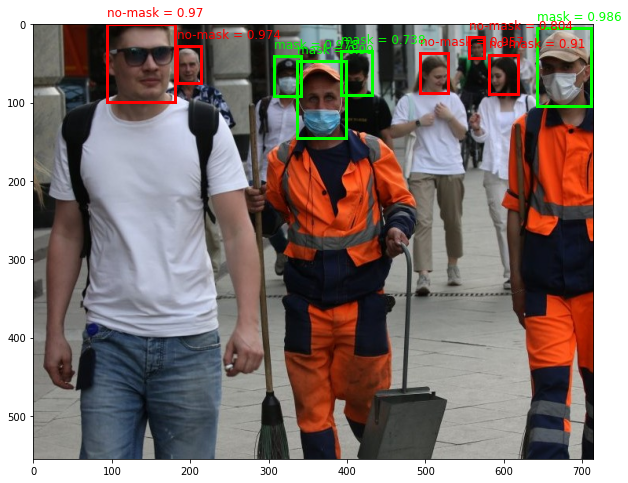

In [263]:
visualise_predictions(min_conf=0.5)

## Test 5

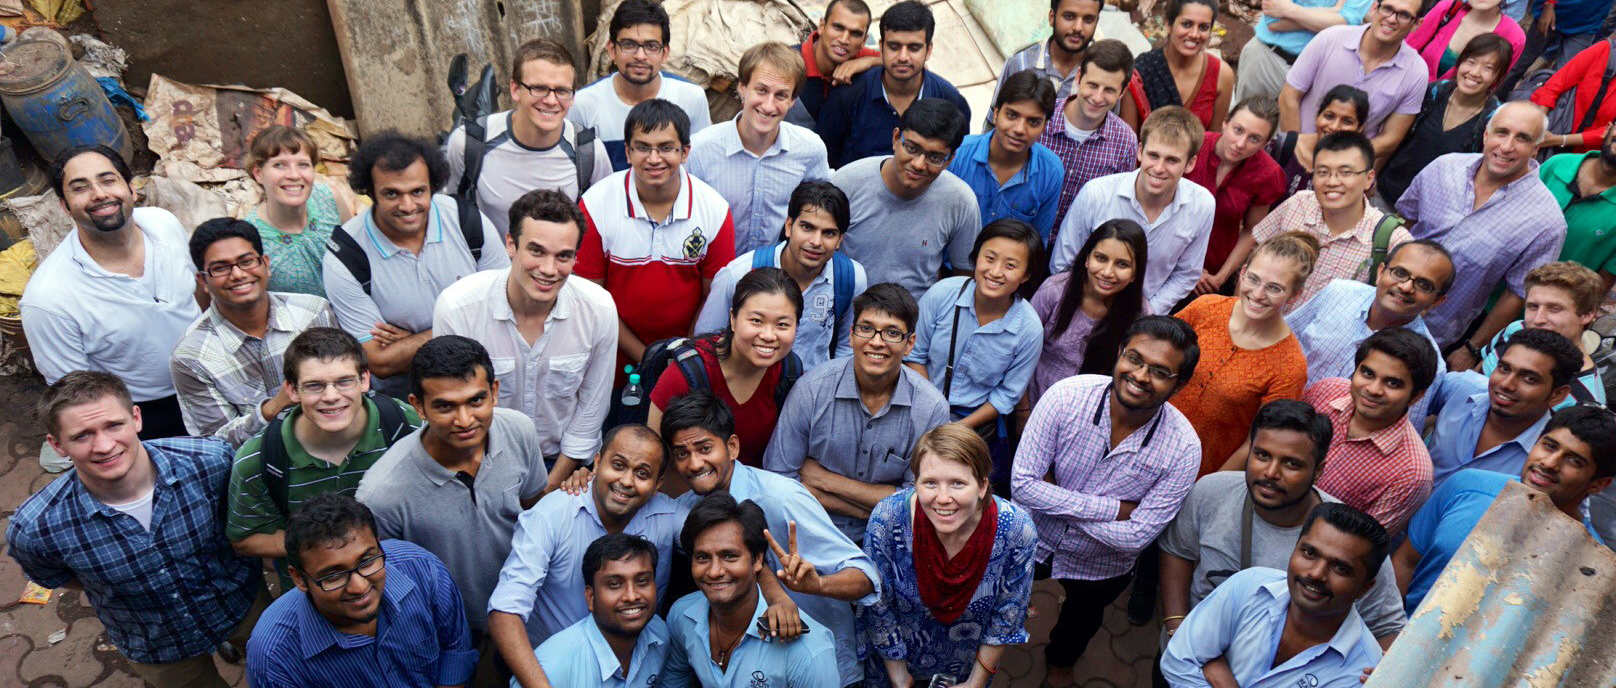

In [273]:
sample_image = os.path.join(testing_images_list[4])
Image(filename=sample_image)

In [274]:
resp = get_predictions(sample_image)


01 no-mask with score = 0.9836814403533936 
Box: {'topX': 0.31302443072926434, 'topY': 0.26802221765804124, 'bottomX': 0.3600610617131822, 'bottomY': 0.4265200229759149} 

02 no-mask with score = 0.9835866093635559 
Box: {'topX': 0.38698280832415133, 'topY': 0.1395172845749628, 'bottomX': 0.42688331689856057, 'bottomY': 0.27316833173156413} 

03 no-mask with score = 0.9825427532196045 
Box: {'topX': 0.15811658603127343, 'topY': 0.17931710433287174, 'bottomX': 0.1964253499287908, 'bottomY': 0.2945228859230324} 

04 no-mask with score = 0.9815629720687866 
Box: {'topX': 0.42193846191039946, 'topY': 0.7190974267492009, 'bottomX': 0.4747702733788916, 'bottomY': 0.8795872710159006} 

05 no-mask with score = 0.9812881946563721 
Box: {'topX': 0.3177125763374437, 'topY': 0.05152332635573399, 'bottomX': 0.35645158543053734, 'bottomY': 0.1924934185371197} 

06 no-mask with score = 0.9801890850067139 
Box: {'topX': 0.44968693039959207, 'topY': 0.3880201336357749, 'bottomX': 0.49847238115681264, 


01 no-mask: [505.847, 184.399, 76.011, 109.046] with score = 0.984
02 no-mask: [625.364, 95.988, 64.479, 91.952] with score = 0.984
03 no-mask: [255.516, 123.37, 61.907, 79.262] with score = 0.983
04 no-mask: [681.853, 494.739, 85.376, 110.417] with score = 0.982
05 no-mask: [513.424, 35.448, 62.602, 96.987] with score = 0.981
06 no-mask: [726.694, 266.958, 78.837, 94.243] with score = 0.98
07 no-mask: [790.506, 171.847, 55.932, 93.014] with score = 0.98
08 no-mask: [880.658, 0.0, 53.179, 78.419] with score = 0.979
09 no-mask: [412.392, 332.265, 87.775, 115.237] with score = 0.978
10 no-mask: [974.534, 214.34, 64.492, 80.381] with score = 0.978
11 no-mask: [661.118, 392.475, 79.369, 97.972] with score = 0.978
12 no-mask: [736.578, 39.174, 64.817, 86.894] with score = 0.978
13 no-mask: [283.497, 323.195, 84.476, 105.877] with score = 0.976
14 no-mask: [366.404, 130.637, 70.889, 103.458] with score = 0.974
15 no-mask: [849.338, 277.223, 68.249, 96.428] with score = 0.974
16 no-mask: [91

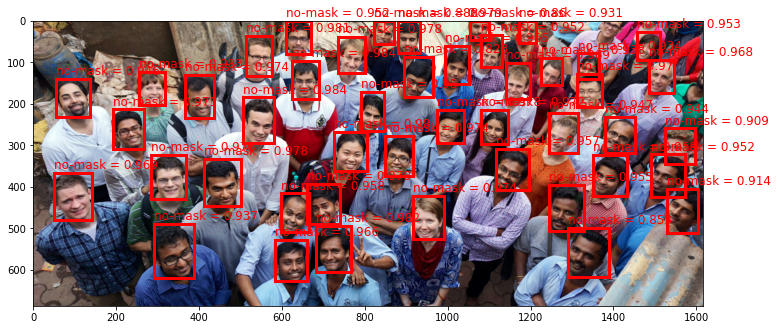

In [275]:
visualise_predictions()

# Test 6

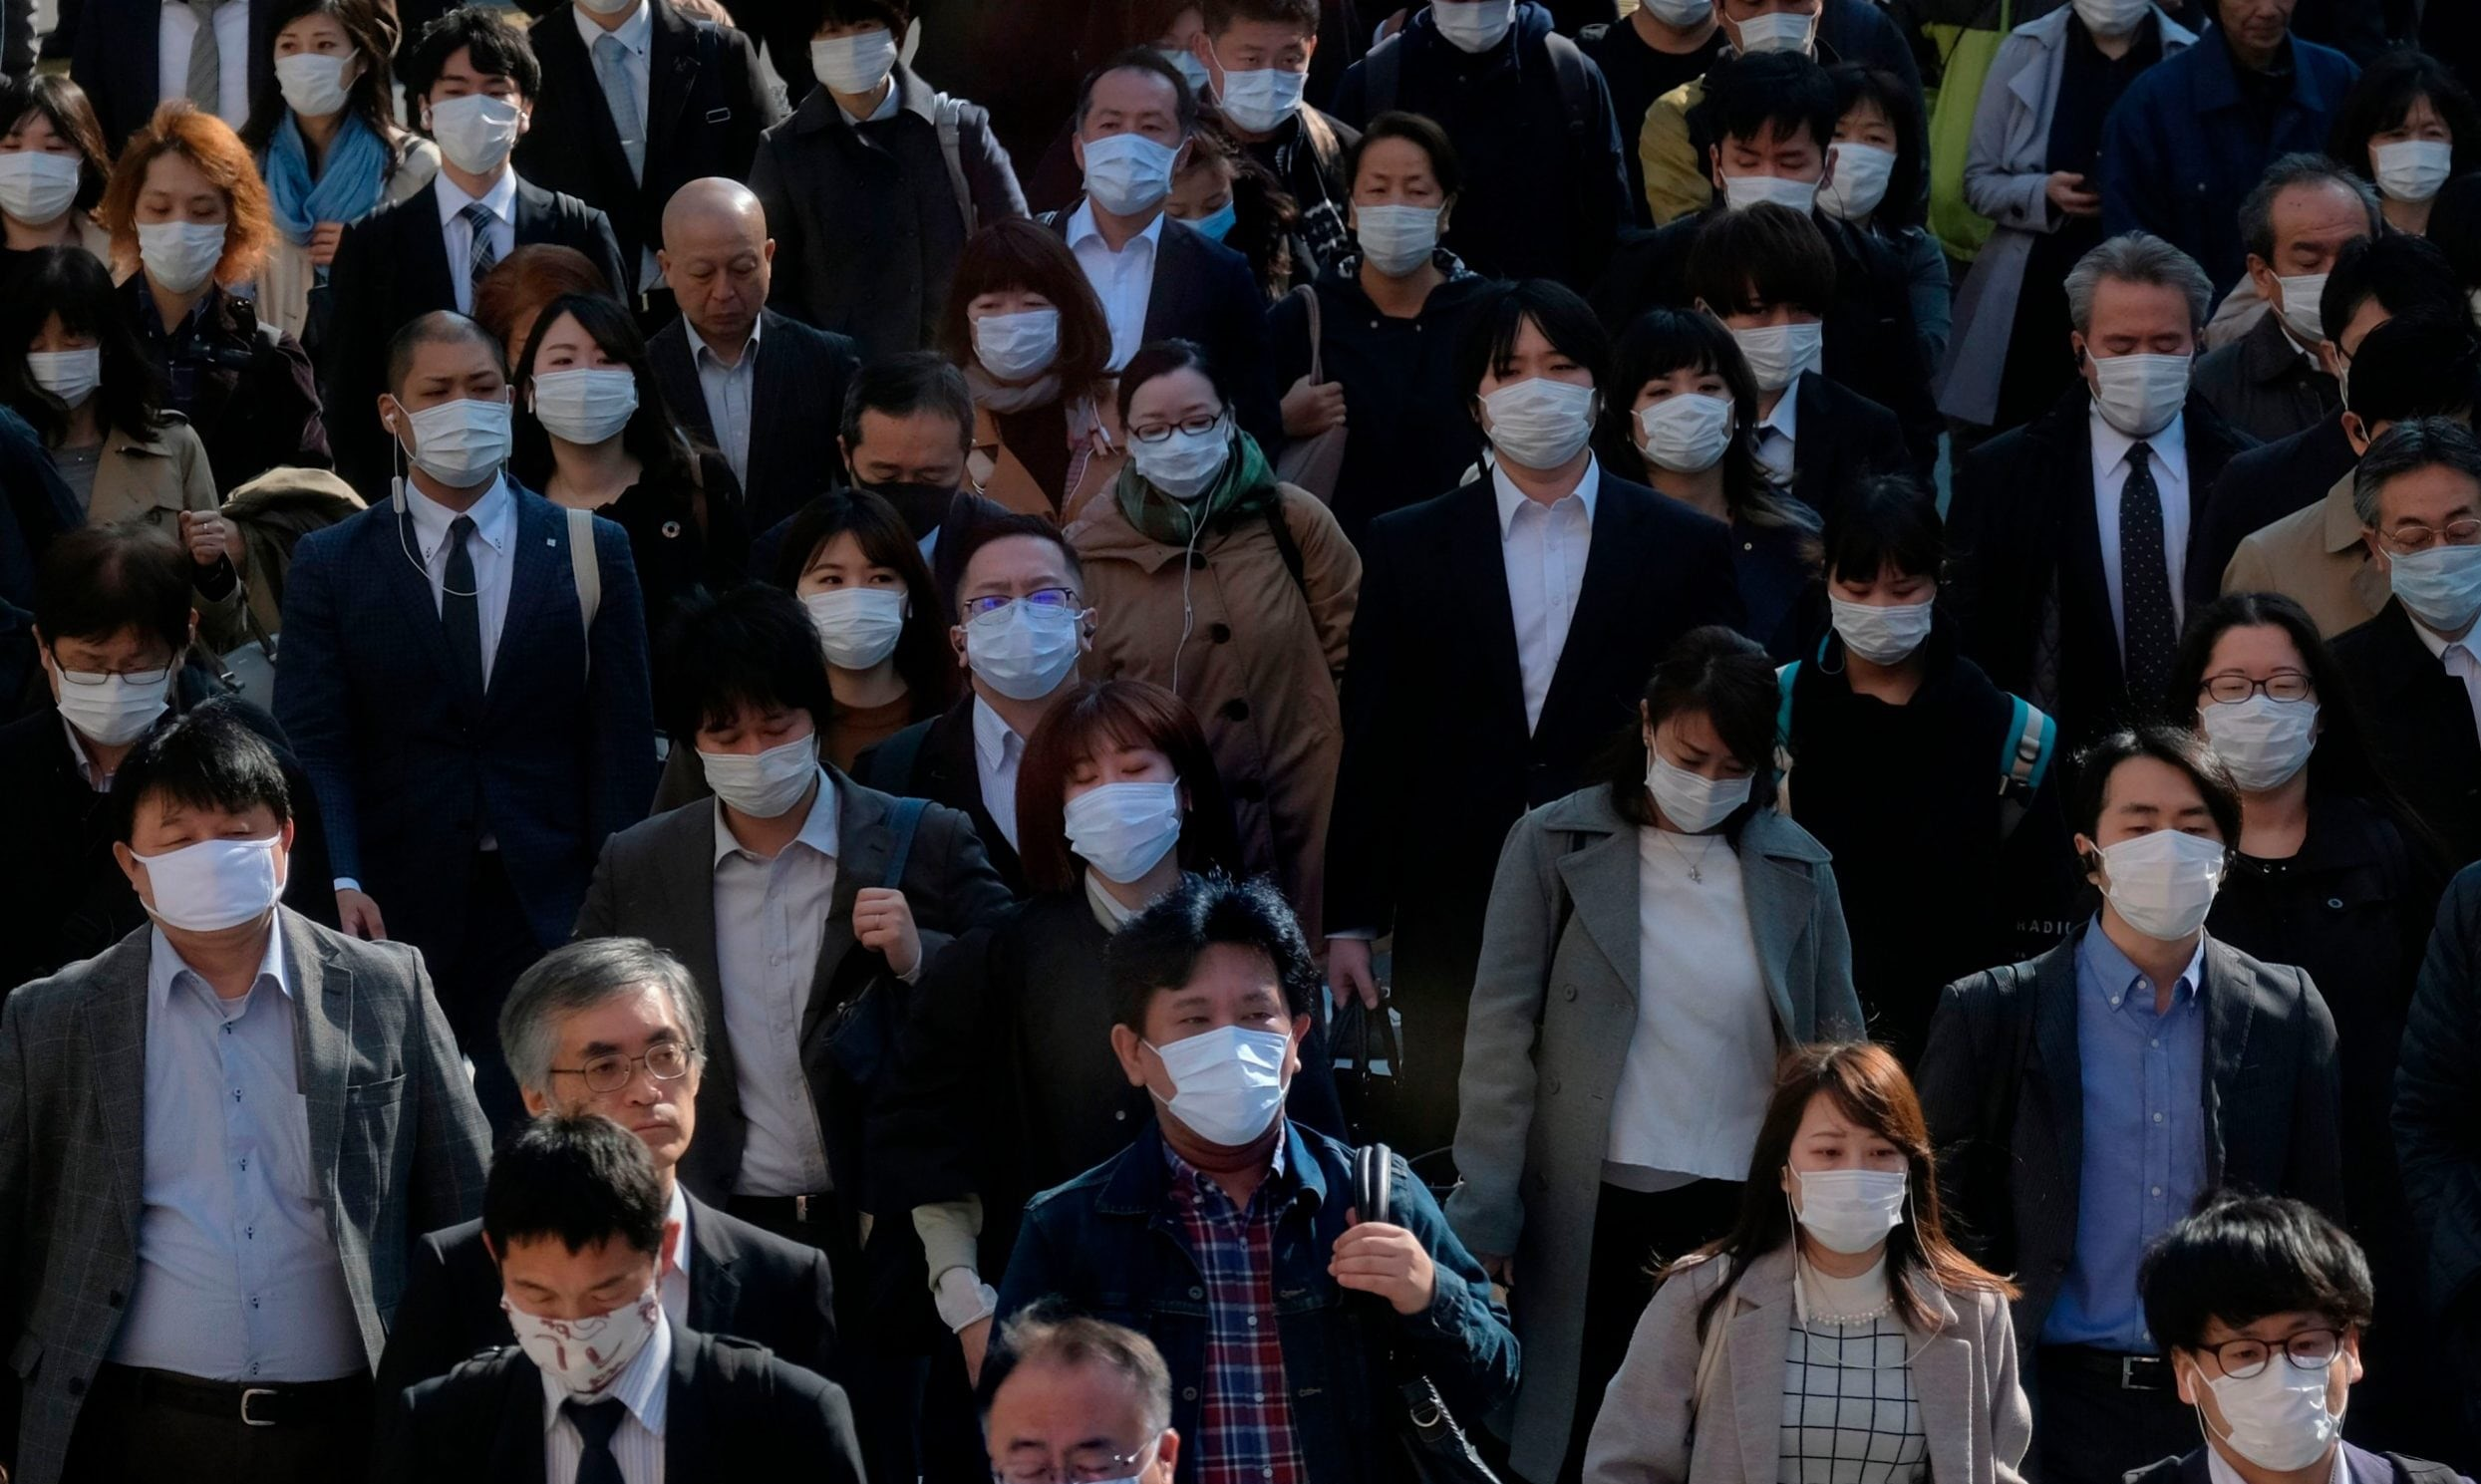

In [267]:
sample_image = os.path.join(testing_images_list[5])
Image(filename=sample_image)

In [268]:
resp = get_predictions(sample_image)


01 mask with score = 0.9918534159660339 
Box: {'topX': 0.20993180570012318, 'topY': 0.18786381640298935, 'bottomX': 0.26347393713549466, 'bottomY': 0.30322403183365504} 

02 mask with score = 0.9883260130882263 
Box: {'topX': 0.042476330450670924, 'topY': 0.46320084458798516, 'bottomX': 0.12666888817579686, 'bottomY': 0.6402691314136842} 

03 mask with score = 0.9881753921508789 
Box: {'topX': 0.15315640995840352, 'topY': 0.19827084549281354, 'bottomX': 0.21155015104069205, 'bottomY': 0.328840430869483} 

04 mask with score = 0.987275242805481 
Box: {'topX': 0.4209898684077158, 'topY': 0.4447703162497392, 'bottomX': 0.48864965381736525, 'bottomY': 0.5980517048270555} 

05 mask with score = 0.9868702292442322 
Box: {'topX': 0.4542480590576659, 'topY': 0.5762702037575647, 'bottomX': 0.5337644413321794, 'bottomY': 0.7815116665797162} 

06 mask with score = 0.9863625168800354 
Box: {'topX': 0.8362494980741642, 'topY': 0.48070224258855904, 'bottomX': 0.9045759798761851, 'bottomY': 0.638853


01 mask: [522.52, 279.729, 133.266, 171.771] with score = 0.992
02 mask: [105.724, 689.706, 209.555, 263.655] with score = 0.988
03 mask: [381.206, 295.225, 145.342, 194.418] with score = 0.988
04 mask: [1047.844, 662.263, 168.405, 228.236] with score = 0.987
05 mask: [1130.623, 858.066, 197.916, 305.605] with score = 0.987
06 mask: [2081.425, 715.766, 170.065, 235.487] with score = 0.986
07 mask: [1472.052, 263.356, 156.542, 219.472] with score = 0.986
08 mask: [1636.539, 619.611, 156.575, 225.889] with score = 0.985
09 mask: [782.131, 490.686, 145.313, 190.612] with score = 0.985
10 mask: [1766.766, 1032.67, 168.776, 236.761] with score = 0.983
11 mask: [1826.361, 465.002, 141.116, 213.383] with score = 0.983
12 mask: [408.233, 4.557, 134.49, 176.657] with score = 0.983
13 mask: [2073.397, 218.133, 144.864, 220.749] with score = 0.982
14 mask: [942.84, 495.677, 162.956, 210.444] with score = 0.982
15 mask: [959.768, 214.086, 135.144, 176.76] with score = 0.981
16 mask: [1619.159, 29

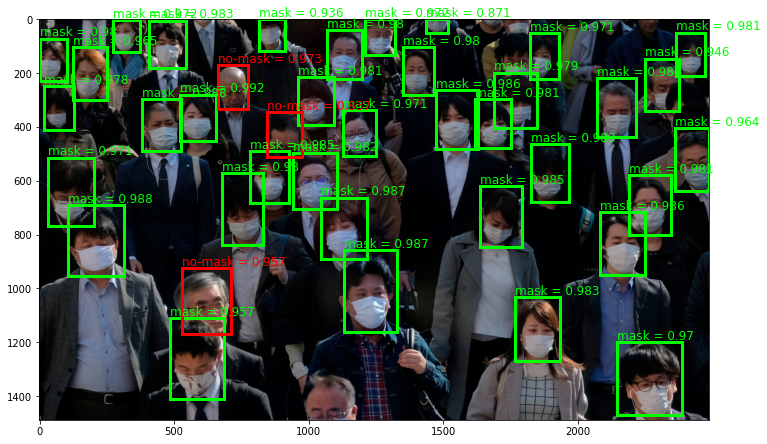

In [269]:
visualise_predictions()

### Delete the deployment and endopoint

In [ ]:
#ml_client.online_endpoints.begin_delete(name=online_endpoint_name)